In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import AdamW, lr_scheduler
import pytorch_lightning as pl
from torchvision import models
import torch_pruning as tp
import wandb
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import networkx as nx
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, ColorJitter, RandomCrop


# Set MPS as the default device
torch.set_default_device("mps")

In [2]:
class AlexNetFineTuner(pl.LightningModule):
    def __init__(self, learning_rate=1e-4, num_classes=10):
        super(AlexNetFineTuner, self).__init__()
        self.save_hyperparameters()

        # Load pre-trained AlexNet
        self.model = models.alexnet(pretrained=False)
        self.model.classifier[6] = torch.nn.Linear(4096, num_classes)  # Update the classifier layer

        # Initialize metrics dictionary
        self.metrics = {
            "pruning_percentage": [],
            "test_accuracy": [],
            "test_loss": [],
            "model_size": []
        }
        
        self.test_outputs = []
    def forward(self, x):
        return self.model(x)

    def print_dependency_graph(self, DG):
        print("\nDependency Graph Details:")
        for module, node in DG.module2node.items():
            print(f"Module: {module}")
            for dep in node.dependencies:
                print(f"    * Target Module: {dep.target.module}")

    def visualize_dependency_graph(self, DG):
        """Visualize the dependency graph using networkx."""
        G = nx.DiGraph()
        for module, node in DG.module2node.items():
            for dep in node.dependencies:
                G.add_edge(str(module), str(dep.target.module))
        plt.figure(figsize=(12, 8))
        nx.draw(G, with_labels=True, node_size=1000, font_size=8, node_color="skyblue", edge_color="gray")
        plt.title("Dependency Graph")
        plt.show()

    def prune_model(self, pruning_percentage=0.2, train_loader=None, val_loader=None, fine_tune_epochs=5, fine_tune_lr=1e-5):
        example_inputs = torch.randn(1, 3, 224, 224, dtype=torch.float32).to("mps")
       
        self.model = self.model.to("mps").to(torch.float32)

        print("MODEL BEFORE PRUNING --------------------->", self.model)

        DG = tp.DependencyGraph().build_dependency(self.model, example_inputs)
        self.print_dependency_graph(DG)
        self.visualize_dependency_graph(DG)

        # Choose a layer to prune
        # layer_to_prune = self.model.conv1
        layers_to_prune = {
            "conv1": self.model.features[0],   # First convolutional layer
            "conv2": self.model.features[3],   # Second convolutional layer
            "conv3": self.model.features[6],   # Third convolutional layer
            "conv4": self.model.features[8],   # Fourth convolutional layer
            "conv5": self.model.features[10],  # Fifth convolutional layer
            "fc1": self.model.classifier[1],   # First fully connected layer
            "fc2": self.model.classifier[4],   # Second fully connected layer
            "fc3": self.model.classifier[6],   # Output fully connected layer
        }
        # # Prune layer
        # num_features = layer_to_prune.out_features
        # pruning_idxs = torch.arange(0, int(num_features * pruning_percentage)).tolist()
        # group = DG.get_pruning_group(layer_to_prune, tp.prune_linear_out_channels, idxs=pruning_idxs)
        # if DG.check_pruning_group(group):
        #     group.prune()

        # Loop over layers and prune
        for layer_name, layer_to_prune in layers_to_prune.items():
            print(f"Pruning layer: {layer_name}")
            
            # Determine layer type and set the appropriate parameter for pruning
            if isinstance(layer_to_prune, torch.nn.Linear):
                num_features = layer_to_prune.out_features
                pruning_function = tp.prune_linear_out_channels  # For fully connected layers
            elif isinstance(layer_to_prune, torch.nn.Conv2d):
                num_features = layer_to_prune.out_channels
                pruning_function = tp.prune_conv_out_channels  # For convolutional layers
            else:
                print(f"Skipping pruning for {layer_name}: Unsupported layer type.")
                continue

            # Generate pruning indices
            pruning_idxs = torch.arange(0, int(num_features * pruning_percentage)).tolist()

            # Generate pruning group
            group = DG.get_pruning_group(layer_to_prune, pruning_function, idxs=pruning_idxs)

            # Check and apply pruning if valid
            if DG.check_pruning_group(group):
                print(f"Pruning {layer_name} with {pruning_percentage * 100}%...")
                group.prune()
            else:
                print(f"Skipping pruning for {layer_name}: Invalid pruning group.")
        # # Loop through all groups and prune only Conv2d and Linear layers
        # for group in DG.get_all_groups():
        #     # Extract the root operation of the pruning group
        #     root_op = group[0]  # The root operation of the pruning group

        #     # Extract the layer module from the root operation
        #     if hasattr(root_op, 'target'):
        #         layer_module = root_op.target.module
        #     else:
        #         print("Skipping group: No target module found in root operation.")
        #         continue

        #     # Proceed only if the layer is Conv2d or Linear
        #     if isinstance(layer_module, (torch.nn.Conv2d, torch.nn.Linear)):
        #         if isinstance(layer_module, torch.nn.Linear):
        #             num_features = layer_module.out_features
        #         elif isinstance(layer_module, torch.nn.Conv2d):
        #             num_features = layer_module.out_channels

        #         # Calculate pruning indices
        #         pruning_idxs = torch.arange(0, int(num_features * pruning_percentage)).tolist()

        #         # Perform pruning if the group is valid
        #         if DG.check_pruning_group(group):
        #             group.prune()
        #             print(f"Pruned Group for layer: {layer_module}")
        #     else:
        #         print(f"Skipping layer: {layer_module} (Not Conv2d or Linear)")


        #  # Iterate over all modules in the model and prune eligible layers
        # for module in self.model.modules():
        #     # Proceed only if the layer type is Linear or Conv2d
        #     if isinstance(module, (torch.nn.Linear, torch.nn.Conv2d)):
        #         # Determine the pruning method and number of features
        #         if isinstance(module, torch.nn.Linear):
        #             prune_method = tp.prune_linear_out_channels
        #             num_features = module.out_features
        #         elif isinstance(module, torch.nn.Conv2d):
        #             prune_method = tp.prune_conv_out_channels
        #             num_features = module.out_channels

        #         # Compute pruning indices based on the percentage
        #         pruning_idxs = torch.arange(0, int(num_features * pruning_percentage)).tolist()

        #         # Get the pruning group for the module
        #         group = DG.get_pruning_group(module, prune_method, idxs=pruning_idxs)

        #         # Prune the layer if the group is valid
        #         if DG.check_pruning_group(group):
        #             group.prune()
        #             print(f"Pruned {module} with {prune_method.__name__}")

        print("MODEL AFTER PRUNING --------------------->", self.model)
        print("PRUNING GROUP ---------------------->", group)

        all_groups = list(DG.get_all_groups())
        print("Number of Groups: --------------------->%d"%len(all_groups))
        print("The last Group: --------------------->", all_groups[-1])

        # Fine-tune the pruned model
        if train_loader is not None and val_loader is not None:
            print("Starting fine-tuning...")
            self.fine_tune_model(self.model, train_loader, val_loader, fine_tune_epochs, fine_tune_lr)

        # Update metrics after pruning
        self.metrics["model_size"].append(sum(p.numel() for p in self.model.parameters() if p.requires_grad))
        self.metrics["pruning_percentage"].append(pruning_percentage * 100)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        images = images.to(torch.float32)  # Convert inputs to float32
        labels = labels.to("mps")  # Ensure labels are on MPS

        print("Images device and dtype:---------------------", images.device, images.dtype)
        print("Labels device and dtype:", labels.device, labels.dtype)

        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean()
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        images = images.to(torch.float32)  # Convert inputs to float32
        labels = labels.to("mps")  # Ensure labels are on MPS
        outputs = self(images)
        val_loss = F.cross_entropy(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        val_acc = (preds == labels).float().mean()
        self.log("val_loss", val_loss, prog_bar=True)
        self.log("val_acc", val_acc, prog_bar=True)
        return val_loss

    def test_step(self, batch, batch_idx):
        images, labels = batch
        images = images.to(torch.float32)
        labels = labels.to("mps")
        outputs = self(images)
        test_loss = F.cross_entropy(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        test_acc = (preds == labels).float().mean()

        # Store batch results for aggregation later
        self.test_outputs.append({"test_loss": test_loss.item(), "test_acc": test_acc.item()})

        # Log per-batch results if needed
        self.log("test_loss_batch", test_loss, prog_bar=True)
        self.log("test_acc_batch", test_acc, prog_bar=True)

        return test_loss

    def on_test_epoch_end(self):
        # Aggregate metrics across batches
        avg_loss = sum(o["test_loss"] for o in self.test_outputs) / len(self.test_outputs)
        avg_acc = sum(o["test_acc"] for o in self.test_outputs) / len(self.test_outputs)

        # Append aggregated metrics for the epoch
        self.metrics["test_accuracy"].append(avg_acc)
        self.metrics["test_loss"].append(avg_loss)

        # Log aggregated metrics
        self.log("test_loss_epoch", avg_loss, prog_bar=True)
        self.log("test_acc_epoch", avg_acc, prog_bar=True)

        # Clear outputs for the next test epoch
        self.test_outputs = []


    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.hparams.learning_rate)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "monitor": "val_loss"}}
    
    def fine_tune_model(self, model, train_loader, val_loader, epochs=5, learning_rate=1e-5):
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
        loss_fn = torch.nn.CrossEntropyLoss()

        for epoch in range(epochs):
            # Training phase
            model.train()
            train_loss, train_correct = 0, 0
            for images, labels in train_loader:
                images, labels = images.to("mps"), labels.to("mps")
                optimizer.zero_grad()
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_correct += (outputs.argmax(dim=1) == labels).sum().item()

            # Validation phase
            model.eval()
            val_loss, val_correct = 0, 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to("mps"), labels.to("mps")
                    outputs = model(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    val_correct += (outputs.argmax(dim=1) == labels).sum().item()

            # Log results for this epoch
            train_acc = train_correct / len(train_loader.dataset)
            val_acc = val_correct / len(val_loader.dataset)
            print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

            # Log metrics
            self.log("fine_tune_train_loss", train_loss, prog_bar=True)
            self.log("fine_tune_train_acc", train_acc, prog_bar=True)
            self.log("fine_tune_val_loss", val_loss, prog_bar=True)
            self.log("fine_tune_val_acc", val_acc, prog_bar=True)





In [3]:
def plot_metrics(metrics):
    print("----------------------->1", metrics["pruning_percentage"], metrics["test_accuracy"])
    print("----------------------->2", metrics["pruning_percentage"], metrics["test_loss"])
    print("----------------------->2", metrics["pruning_percentage"], metrics["model_size"])

    plt.figure()
    plt.plot(metrics["pruning_percentage"], metrics["test_accuracy"], marker='o', label="Accuracy")
    plt.title("Test Accuracy vs. Pruning Percentage")
    plt.xlabel("Pruning Percentage (%)")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(metrics["pruning_percentage"], metrics["test_loss"], marker='o', color="orange", label="Loss")
    plt.title("Test Loss vs. Pruning Percentage")
    plt.xlabel("Pruning Percentage (%)")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(metrics["pruning_percentage"], metrics["model_size"], marker='o', color="green", label="Model Size")
    plt.title("Model Size vs. Pruning Percentage")
    plt.xlabel("Pruning Percentage (%)")
    plt.ylabel("Number of Parameters")
    plt.grid(True)
    plt.legend()
    plt.show()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: p-mangal (p-mangal-university-of-amsterdam). Use `wandb login --relogin` to force relogin


Files already downloaded and verified
Files already downloaded and verified


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Applying 0% pruning...
MODEL BEFORE PRUNING ---------------------> AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False

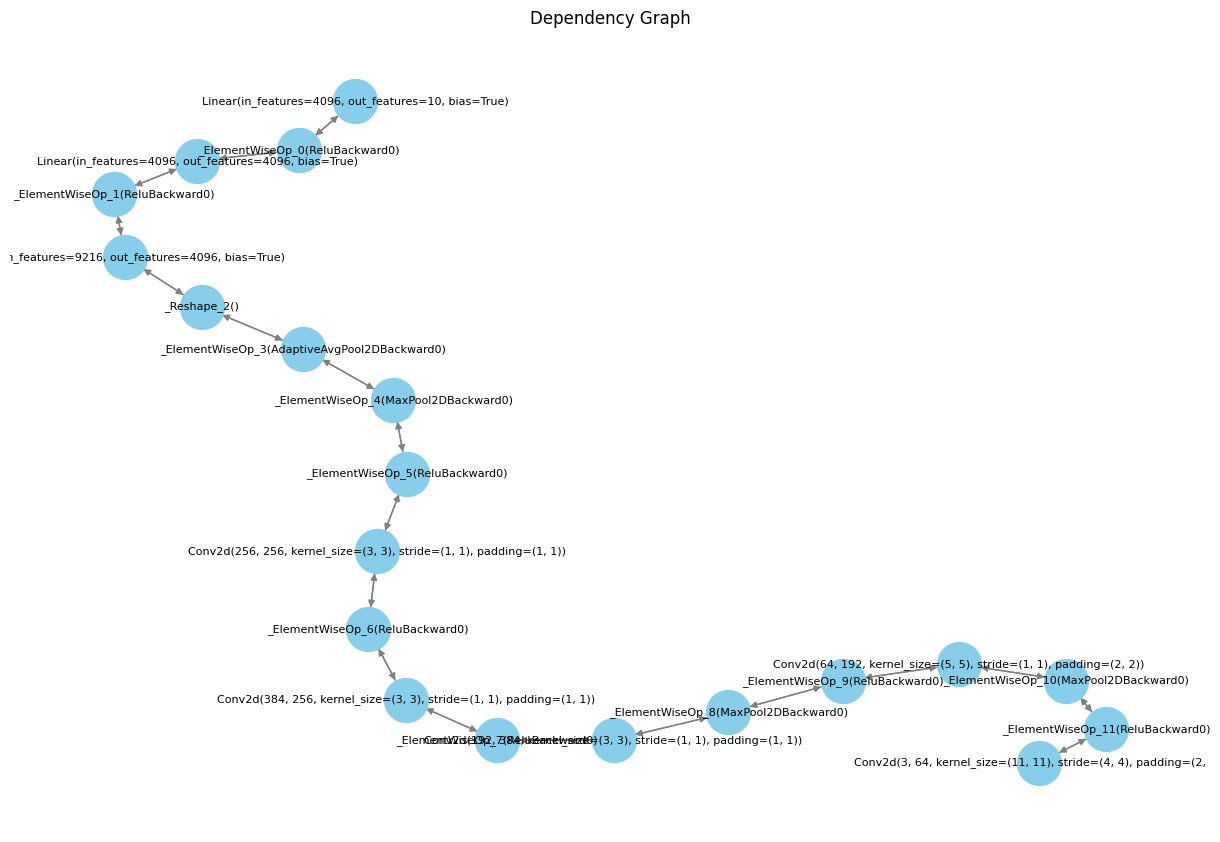

Pruning layer: conv1
Pruning conv1 with 0%...
Pruning layer: conv2
Pruning conv2 with 0%...
Pruning layer: conv3
Pruning conv3 with 0%...
Pruning layer: conv4
Pruning conv4 with 0%...
Pruning layer: conv5
Pruning conv5 with 0%...
Pruning layer: fc1
Pruning fc1 with 0%...
Pruning layer: fc2
Pruning fc2 with 0%...
Pruning layer: fc3
Pruning fc3 with 0%...
MODEL AFTER PRUNING ---------------------> AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9):

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_batch       │    0.8891000151634216     │
│      test_acc_epoch       │    0.8889776468276978     │
│      test_loss_batch      │    0.3239855468273163     │
│      test_loss_epoch      │    0.32431888580322266    │
└───────────────────────────┴───────────────────────────┘

Applying 10.0% pruning...
MODEL BEFORE PRUNING ---------------------> AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=Fa

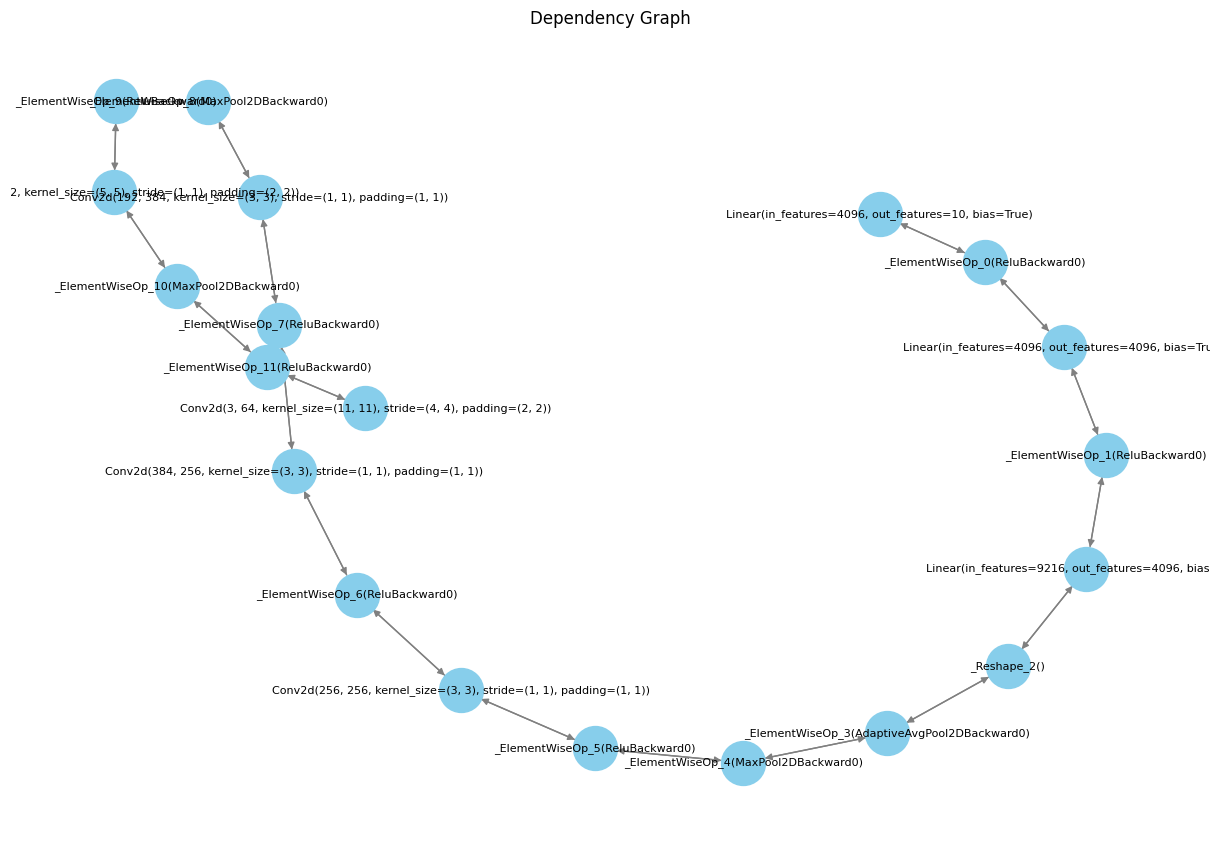

Pruning layer: conv1
Pruning conv1 with 10.0%...
Pruning layer: conv2
Pruning conv2 with 10.0%...
Pruning layer: conv3
Pruning conv3 with 10.0%...
Pruning layer: conv4
Pruning conv4 with 10.0%...
Pruning layer: conv5
Pruning conv5 with 10.0%...
Pruning layer: fc1
Pruning fc1 with 10.0%...
Pruning layer: fc2
Pruning fc2 with 10.0%...
Pruning layer: fc3
Pruning fc3 with 10.0%...
MODEL AFTER PRUNING ---------------------> AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 58, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(58, 173, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(173, 346, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(346, 231, kernel_size=(3, 3), stride=(1, 1), 

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_batch       │   0.027300000190734863    │
│      test_acc_epoch       │    0.02725639007985592    │
│      test_loss_batch      │     4.416304111480713     │
│      test_loss_epoch      │     4.418412208557129     │
└───────────────────────────┴───────────────────────────┘

Applying 20.0% pruning...
MODEL BEFORE PRUNING ---------------------> AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 58, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(58, 173, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(173, 346, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(346, 231, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(231, 231, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=Fa

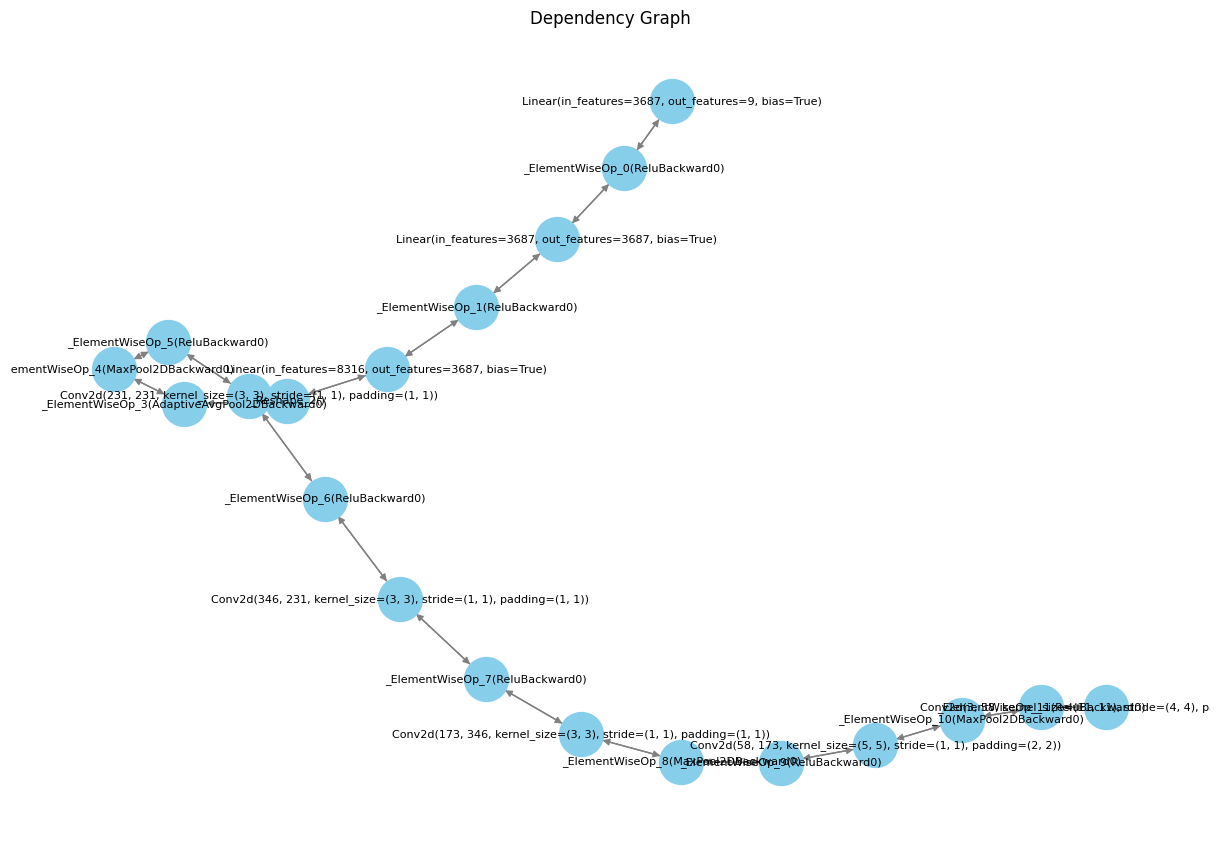

Pruning layer: conv1
Pruning conv1 with 20.0%...
Pruning layer: conv2
Pruning conv2 with 20.0%...
Pruning layer: conv3
Pruning conv3 with 20.0%...
Pruning layer: conv4
Pruning conv4 with 20.0%...
Pruning layer: conv5
Pruning conv5 with 20.0%...
Pruning layer: fc1
Pruning fc1 with 20.0%...
Pruning layer: fc2
Pruning fc2 with 20.0%...
Pruning layer: fc3
Pruning fc3 with 20.0%...
MODEL AFTER PRUNING ---------------------> AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 47, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(47, 139, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(139, 277, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(277, 185, kernel_size=(3, 3), stride=(1, 1), 

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of Groups: --------------------->8
The last Group: ---------------------> 
--------------------------------
          Pruning Group
--------------------------------
[0] prune_out_channels on features.0 (Conv2d(3, 47, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))) => prune_out_channels on features.0 (Conv2d(3, 47, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))), len(idxs)=47
[1] prune_out_channels on features.0 (Conv2d(3, 47, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))) => prune_out_channels on _ElementWiseOp_11(ReluBackward0), len(idxs)=47
[2] prune_out_channels on _ElementWiseOp_11(ReluBackward0) => prune_out_channels on _ElementWiseOp_10(MaxPool2DBackward0), len(idxs)=47
[3] prune_out_channels on _ElementWiseOp_10(MaxPool2DBackward0) => prune_in_channels on features.3 (Conv2d(47, 139, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))), len(idxs)=47
--------------------------------



Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_batch       │    0.08190000057220459    │
│      test_acc_epoch       │    0.08186900615692139    │
│      test_loss_batch      │    2.2992920875549316     │
│      test_loss_epoch      │     2.299860954284668     │
└───────────────────────────┴───────────────────────────┘

Applying 30.0% pruning...
MODEL BEFORE PRUNING ---------------------> AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 47, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(47, 139, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(139, 277, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(277, 185, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(185, 185, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=Fa

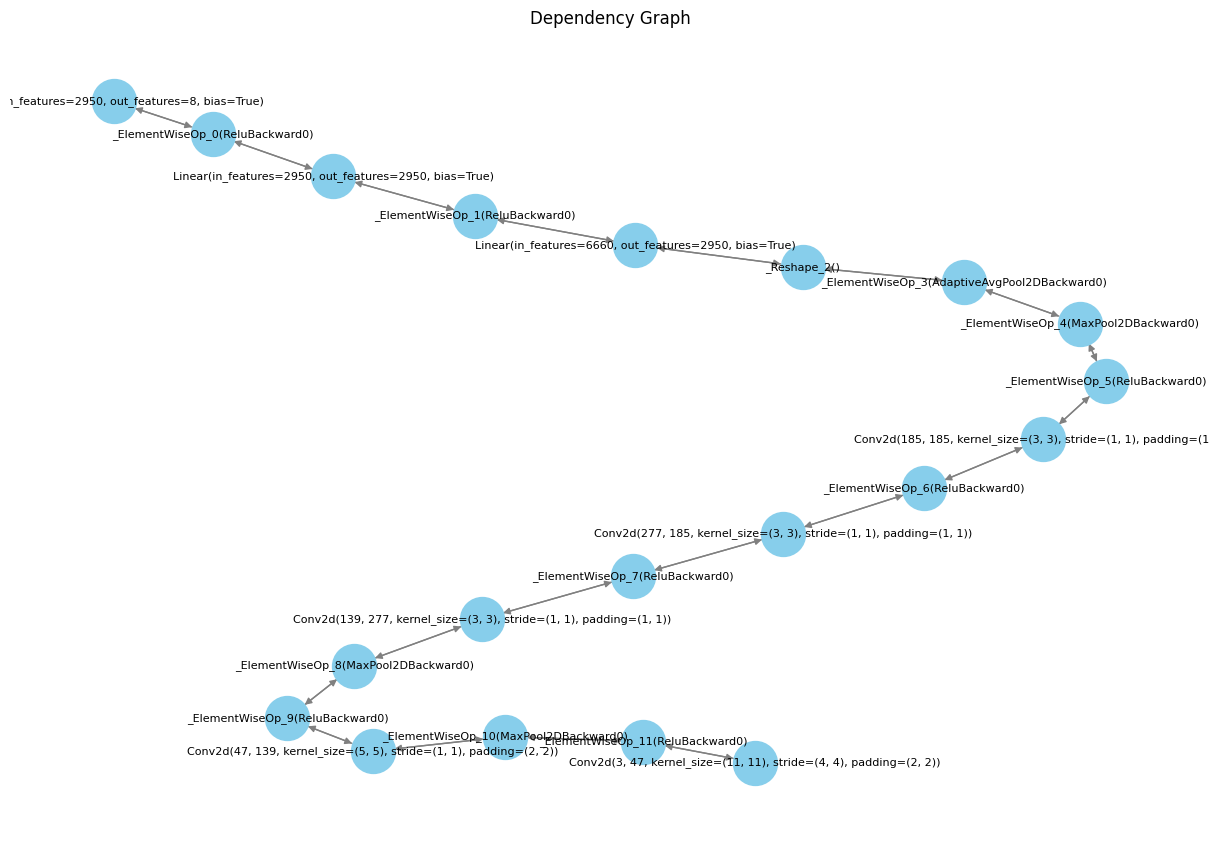

Pruning layer: conv1
Pruning conv1 with 30.0%...
Pruning layer: conv2
Pruning conv2 with 30.0%...
Pruning layer: conv3
Pruning conv3 with 30.0%...
Pruning layer: conv4
Pruning conv4 with 30.0%...
Pruning layer: conv5
Pruning conv5 with 30.0%...
Pruning layer: fc1
Pruning fc1 with 30.0%...
Pruning layer: fc2
Pruning fc2 with 30.0%...
Pruning layer: fc3
Pruning fc3 with 30.0%...
MODEL AFTER PRUNING ---------------------> AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 33, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(33, 98, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(98, 194, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(194, 130, kernel_size=(3, 3), stride=(1, 1), pa

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



The last Group: ---------------------> 
--------------------------------
          Pruning Group
--------------------------------
[0] prune_out_channels on features.0 (Conv2d(3, 33, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))) => prune_out_channels on features.0 (Conv2d(3, 33, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))), len(idxs)=33
[1] prune_out_channels on features.0 (Conv2d(3, 33, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))) => prune_out_channels on _ElementWiseOp_11(ReluBackward0), len(idxs)=33
[2] prune_out_channels on _ElementWiseOp_11(ReluBackward0) => prune_out_channels on _ElementWiseOp_10(MaxPool2DBackward0), len(idxs)=33
[3] prune_out_channels on _ElementWiseOp_10(MaxPool2DBackward0) => prune_in_channels on features.3 (Conv2d(33, 98, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))), len(idxs)=33
--------------------------------



Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_batch       │    0.08749999850988388    │
│      test_acc_epoch       │    0.08746006339788437    │
│      test_loss_batch      │    1.1688703298568726     │
│      test_loss_epoch      │    1.1690175533294678     │
└───────────────────────────┴───────────────────────────┘

Applying 40.0% pruning...
MODEL BEFORE PRUNING ---------------------> AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 33, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(33, 98, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(98, 194, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(194, 130, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(130, 130, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=Fals

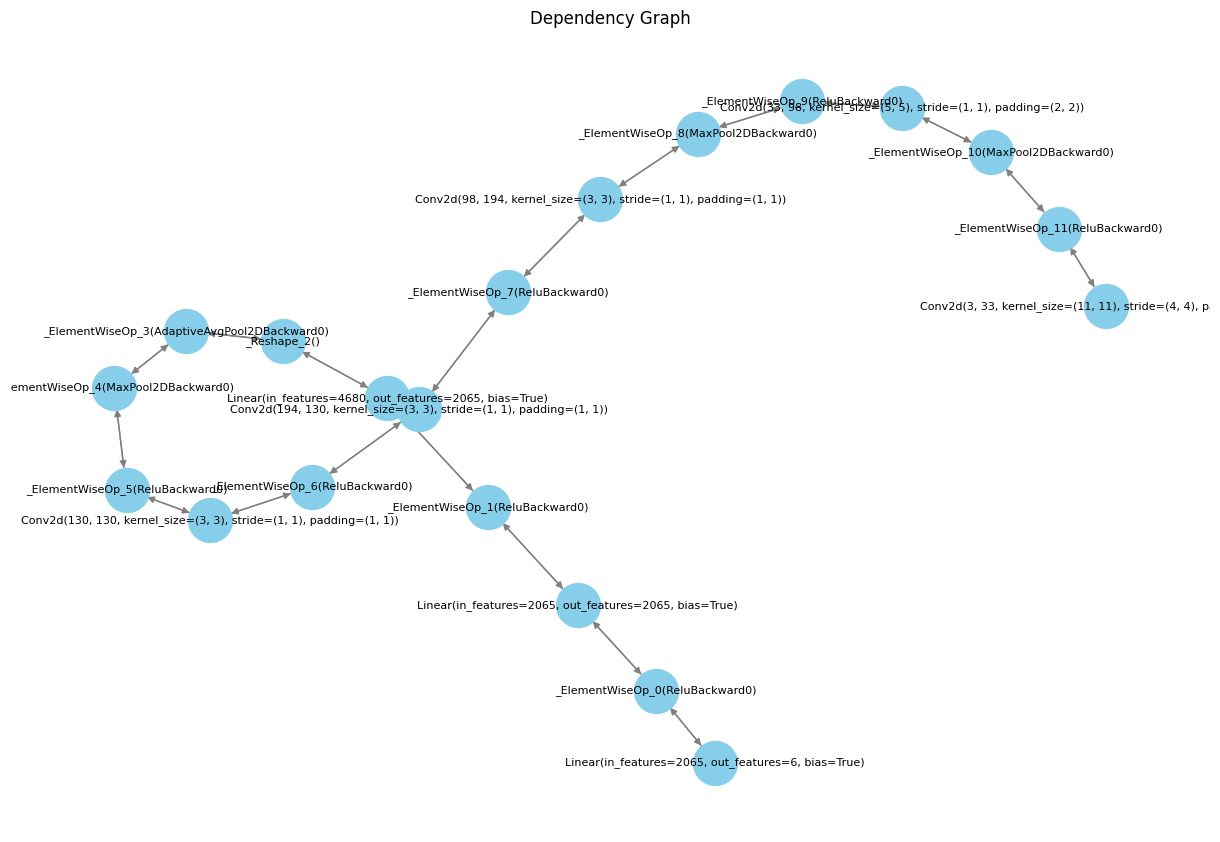

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Pruning layer: conv1
Pruning conv1 with 40.0%...
Pruning layer: conv2
Pruning conv2 with 40.0%...
Pruning layer: conv3
Pruning conv3 with 40.0%...
Pruning layer: conv4
Pruning conv4 with 40.0%...
Pruning layer: conv5
Pruning conv5 with 40.0%...
Pruning layer: fc1
Pruning fc1 with 40.0%...
Pruning layer: fc2
Pruning fc2 with 40.0%...
Pruning layer: fc3
Pruning fc3 with 40.0%...
MODEL AFTER PRUNING ---------------------> AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 20, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 59, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(59, 117, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(117, 78, kernel_size=(3, 3), stride=(1, 1), pad

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_batch       │    0.09780000150203705    │
│      test_acc_epoch       │    0.09784345328807831    │
│      test_loss_batch      │    0.5627467036247253     │
│      test_loss_epoch      │    0.5628370642662048     │
└───────────────────────────┴───────────────────────────┘

Applying 50.0% pruning...
MODEL BEFORE PRUNING ---------------------> AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 20, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 59, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(59, 117, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(117, 78, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(78, 78, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)


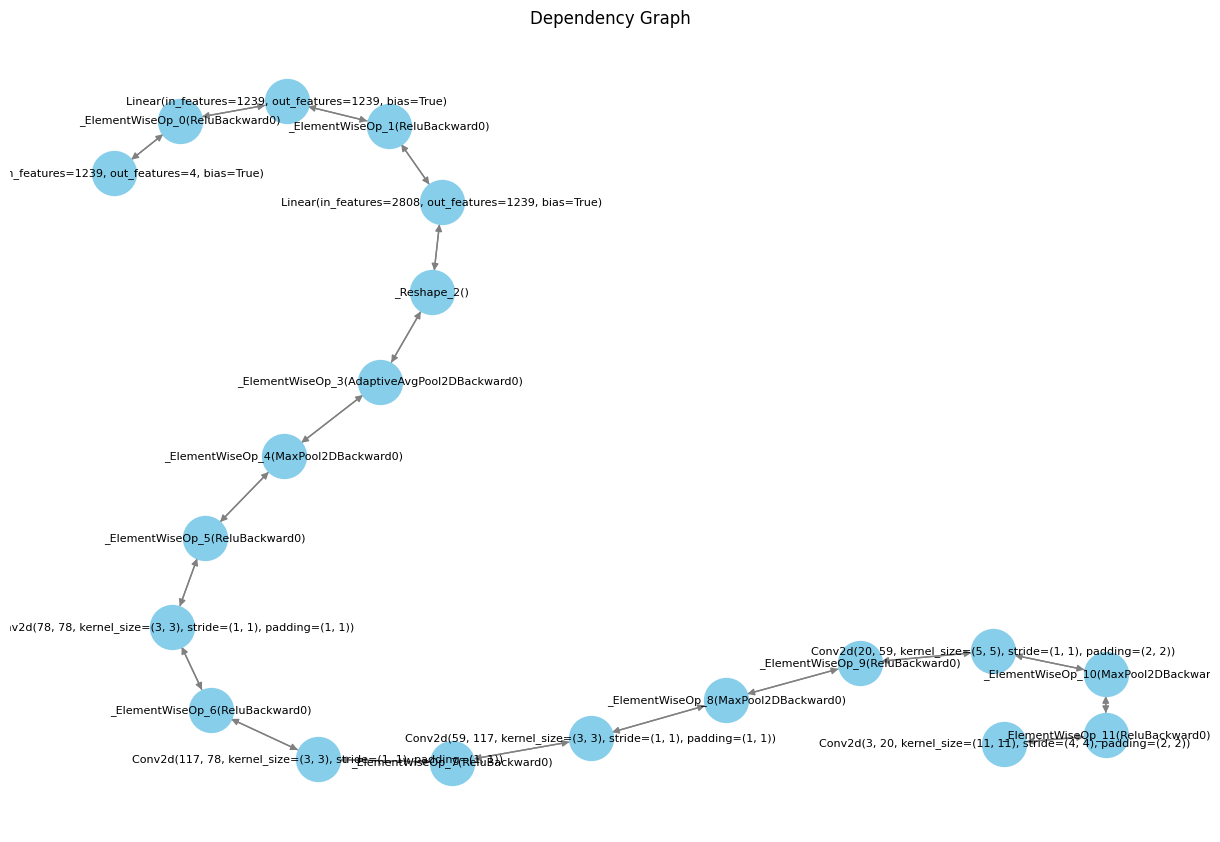

Pruning layer: conv1
Pruning conv1 with 50.0%...
Pruning layer: conv2
Pruning conv2 with 50.0%...
Pruning layer: conv3
Pruning conv3 with 50.0%...
Pruning layer: conv4
Pruning conv4 with 50.0%...
Pruning layer: conv5
Pruning conv5 with 50.0%...
Pruning layer: fc1
Pruning fc1 with 50.0%...
Pruning layer: fc2
Pruning fc2 with 50.0%...
Pruning layer: fc3
Pruning fc3 with 50.0%...
MODEL AFTER PRUNING ---------------------> AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 10, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(10, 30, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(30, 59, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(59, 39, kernel_size=(3, 3), stride=(1, 1), paddi

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_batch       │    0.10459999740123749    │
│      test_acc_epoch       │    0.10463258624076843    │
│      test_loss_batch      │    0.13838091492652893    │
│      test_loss_epoch      │    0.13836663961410522    │
└───────────────────────────┴───────────────────────────┘

----------------------->1 [0, 10.0, 20.0, 30.0, 40.0, 50.0] [0.8889776357827476, 0.027256389776357828, 0.08186900958466453, 0.08746006389776358, 0.09784345047923322, 0.10463258785942492]
----------------------->2 [0, 10.0, 20.0, 30.0, 40.0, 50.0] [0.324318877733744, 4.418412188752391, 2.299861018269207, 1.1690176117915314, 0.5628370581724392, 0.1383666348176452]
----------------------->2 [0, 10.0, 20.0, 30.0, 40.0, 50.0] [57044810, 46306875, 29675984, 14588553, 5257800, 1318997]


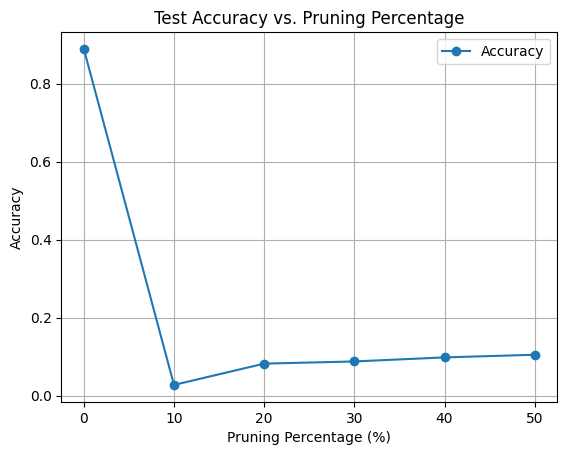

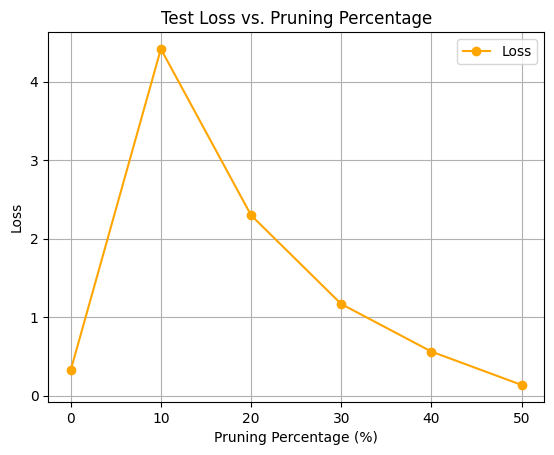

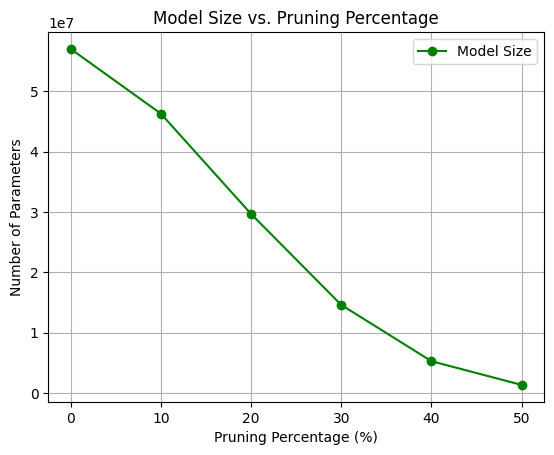

epoch,▁▁▁▁▁▁
test_acc_batch,█▁▁▁▂▂
test_acc_epoch,█▁▁▁▂▂
test_loss_batch,▁█▅▃▂▁
test_loss_epoch,▁█▅▃▂▁
trainer/global_step,▁▁▁▁▁▁
epoch,0
test_acc_batch,0.1046
test_acc_epoch,0.10463
test_loss_batch,0.13838
test_loss_epoch,0.13837


In [4]:
def main():
    wandb.init(project='alexnet_depGraph', name='AlexNet_Run')
    wandb_logger = WandbLogger(log_model=False)

    transform = Compose([
        Resize((224, 224)),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=32)

    checkpoint_path = "../checkpointsAlex/best-checkpoint.ckpt"
    model = AlexNetFineTuner.load_from_checkpoint(checkpoint_path)
    model = model.to(torch.float32)
    for param in model.parameters():
        param.data = param.data.to(torch.float32).to("mps")
        if param.grad is not None:
            param.grad = param.grad.to(torch.float32).to("mps")

    # print(f"Model device-------------------: {next(model.parameters()).device}, dtype: {next(model.parameters()).dtype}")

    pruning_percentages = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
    for pruning_percentage in pruning_percentages:
        print(f"Applying {pruning_percentage * 100}% pruning...")
        model.prune_model(pruning_percentage=pruning_percentage)
        trainer = pl.Trainer(logger=wandb_logger)
        trainer.test(model, dataloaders=test_dataloader)

    plot_metrics(model.metrics)
    wandb.finish()


if __name__ == "__main__":
    main()